# FastAi-UNET-Se_ResNeXT34

> Training notebook for this architecture.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from steel_segmentation.metadata import *
from steel_segmentation.masks import *
from steel_segmentation.dataloaders import *
from steel_segmentation.metrics import *
from steel_segmentation.trainer import *
from steel_segmentation.loss import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

In [3]:
fastai.__version__

'2.2.3'

In [4]:
torch.__version__

'1.7.1+cu101'

In [5]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [6]:
torch.cuda.empty_cache()

In [7]:
!nvidia-smi

Wed Mar 10 15:42:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 32%   41C    P8     6W / 180W |      4MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
print_competition_data(models_dir)

../models/fastai-UNET-ResNet34-256-stage5.pth
../models/fastai-UNET-XResNeXt34-128x800.pth
../models/fastai-UNET-XResNeXt34.pth
../models/.ipynb_checkpoints
../models/kaggle-UNET-ResNet34.pth
../models/fastai-UNET-ResNet34-256-stage3.pth
../models/kaggle-FPN-ResNet34.pth


In [9]:
arch = xse_resnext34

In [10]:
seg_metrics = [DiceMulti()]

## Small size

In [11]:
bs = 16 # 16 gb
dls = get_segmentation_dls(bs, size=(128, 800))

In [13]:
cbs = [
    ShowGraphCallback(), 
    # the save model callback in fit
    #SaveModelCallback(fname="fastai-UNET-XResNeXt34-128x800", with_opt=True),
    GradientAccumulation(n_acc=32)
]
segmentation_learner = unet_learner(
    dls=dls, 
    arch=arch, 
    metrics=seg_metrics, 
    pretrained=True, 
    cbs=cbs,
    model_dir=models_dir
).to_fp16()

In [14]:
# reloading state_dict
segmentation_learner = segmentation_learner.load("fastai-UNET-XResNeXt34-128x800")
# segmentation_learner.validate()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


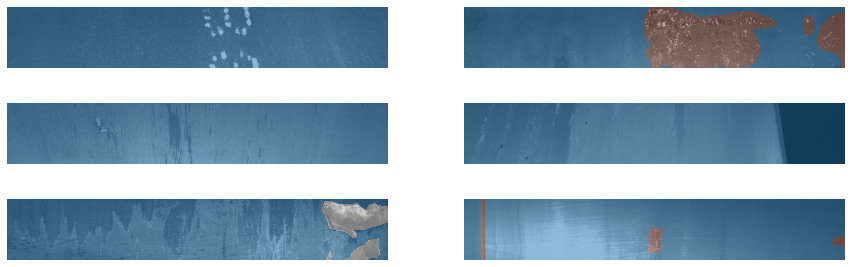

In [16]:
segmentation_learner.dls.show_batch(figsize=(15,5), ncols=2)

In [13]:
segmentation_learner.summary()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/metrics.py:376: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


DynamicUnet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 64 x 400  
Conv2d                                    864        False     
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       False     
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 64 x 400  
Conv2d                                    18432      False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 12

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=4.365158383734524e-05)

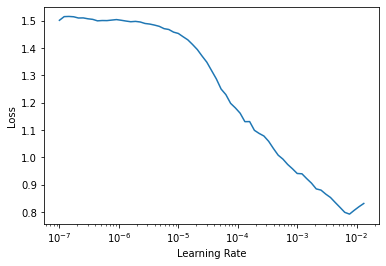

In [17]:
segmentation_learner.lr_find()

epoch,train_loss,valid_loss,dice_multi,time
0,0.123493,0.123763,0.248825,12:28
1,0.110371,0.118004,0.241562,12:28
2,0.112678,0.110167,0.251399,12:28
3,0.100330,0.102569,0.265920,12:28
4,0.094040,0.089146,0.305323,12:27
5,0.090142,0.084011,0.365358,12:27
6,0.082269,0.085229,0.352996,12:26
7,0.084879,0.082785,0.373287,12:28
8,0.080693,0.073517,0.400721,12:27
9,0.070520,0.071543,0.431810,12:27


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (pos >= pcts).nonzero().max()


Better model found at epoch 0 with valid_loss value: 0.12376271933317184.


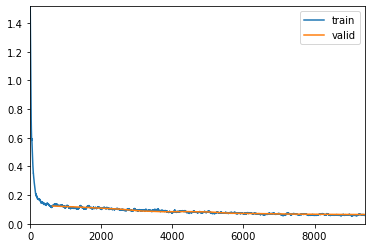

Better model found at epoch 1 with valid_loss value: 0.11800381541252136.
Better model found at epoch 2 with valid_loss value: 0.11016674339771271.
Better model found at epoch 3 with valid_loss value: 0.1025685966014862.
Better model found at epoch 4 with valid_loss value: 0.08914550393819809.
Better model found at epoch 5 with valid_loss value: 0.08401143550872803.
Better model found at epoch 7 with valid_loss value: 0.0827852115035057.
Better model found at epoch 8 with valid_loss value: 0.073516845703125.
Better model found at epoch 9 with valid_loss value: 0.07154327630996704.
Better model found at epoch 10 with valid_loss value: 0.06962405145168304.
Better model found at epoch 11 with valid_loss value: 0.06719432026147842.
Better model found at epoch 12 with valid_loss value: 0.06623176485300064.
Better model found at epoch 13 with valid_loss value: 0.06516284495592117.
Better model found at epoch 14 with valid_loss value: 0.06496747583150864.


In [18]:
segmentation_learner.fit_one_cycle(15, lr_max=3e-4)

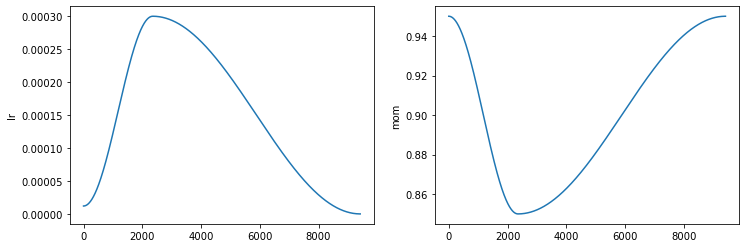

In [21]:
segmentation_learner.recorder.plot_sched()

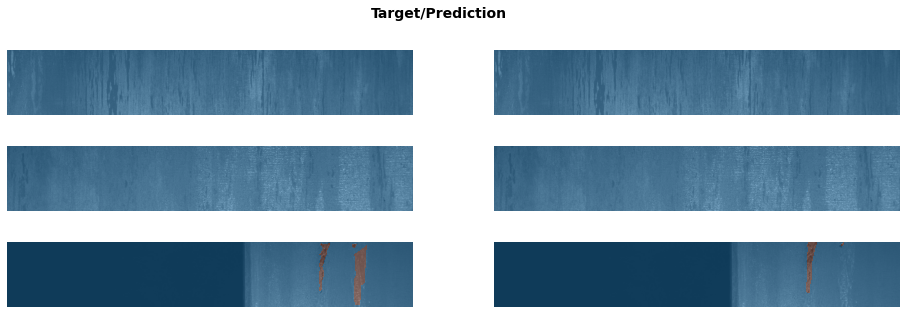

In [34]:
segmentation_learner.show_results(ds_idx=1, figsize=(16,5))

SuggestedLRs(lr_min=1.737800812406931e-06, lr_steep=5.754399353463668e-06)

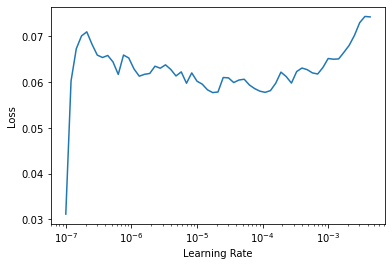

In [35]:
segmentation_learner.unfreeze()
segmentation_learner.lr_find()

In [42]:
segmentation_learner.dls = dls
segmentation_learner.summary()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/metrics.py:376: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


DynamicUnet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 64 x 400  
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 64 x 400  
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 12

epoch,train_loss,valid_loss,dice_multi,time
0,0.061589,0.065604,0.452728,13:22
1,0.062219,0.065077,0.461614,13:24
2,0.059318,0.064651,0.460563,13:18


Better model found at epoch 0 with valid_loss value: 0.06560434401035309.


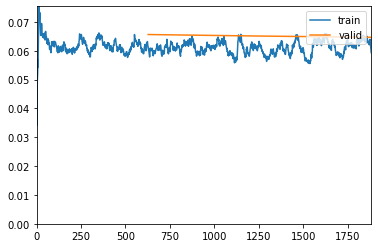

Better model found at epoch 1 with valid_loss value: 0.06507739424705505.
Better model found at epoch 2 with valid_loss value: 0.06465104222297668.


In [36]:
segmentation_learner.fit_one_cycle(3, lr_max=slice(1e-6,1e-5))

In [17]:
segmentation_learner.loss_func = lovasz_softmax

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=1.9054607491852948e-06)

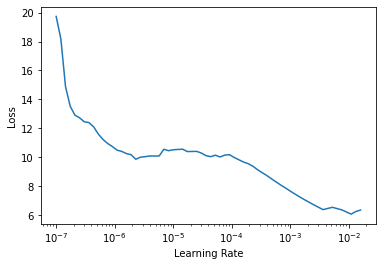

In [18]:
segmentation_learneration_learner.lr_find()

In [ ]:
segmentation_learner.fit_one_cycle(
    n_epoch=10, 
    lr_max=3e-4,
    cbs=[SaveModelCallback(fname="fastai-UNET-XResNeXt34-128x800-lovloss", with_opt=True)])

epoch,train_loss,valid_loss,dice_multi,time


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (pos >= pcts).nonzero().max()


In [ ]:
segmentation_learner.recorder.plot_losses()

## Full size

In [11]:
bs = 4 # 16 gb
dls = get_segmentation_dls(bs, size=(256, 1600))

In [18]:
cbs = [
    ShowGraphCallback(), 
    # SaveModelCallback(fname="fastai-UNET-XResNeXt34-256x1600", with_opt=True),
    GradientAccumulation(n_acc=32)
]
segmentation_learner = unet_learner(
    dls=dls, 
    arch=arch, 
    loss_func=lovasz_softmax,
    metrics=seg_metrics, 
    pretrained=True, 
    cbs=cbs,
    model_dir=models_dir
).to_fp16()

In [19]:
segmentation_learner = segmentation_learner.load("fastai-UNET-XResNeXt34-128x800")

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


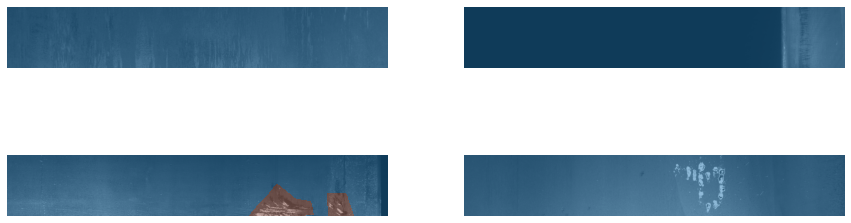

In [17]:
segmentation_learner.dls.valid.show_batch(figsize=(15,5), ncols=2)

After training with BCE, train with another loss function ([discussion](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/114297)).

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=0.0005754399462603033)

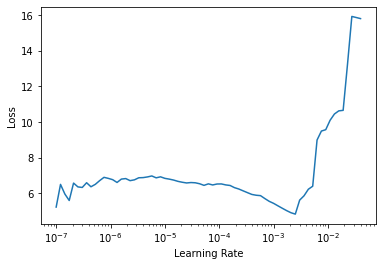

In [20]:
segmentation_learner.lr_find()

In [39]:
segmentation_learner.validate() # make a mistake because with the callback i overwrite the model

Better model found at epoch 0 with valid_loss value: 0.3584755567690336.


(#2) [0.10165372490882874,0.3584755567690336]

In [15]:
segmentation_learner.model = segmentation_learner.model.cuda()

In [15]:
x,y = segmentation_learner.dls.one_batch()

In [16]:
preds = segmentation_learner.model(x)

In [17]:
x.shape, preds.shape, y.shape

(torch.Size([24, 3, 128, 800]),
 torch.Size([24, 5, 128, 800]),
 torch.Size([24, 128, 800]))

In [20]:
segmentation_learner.loss_func??

In [29]:
lovasz_softmax(preds, y)

TensorImage(14.6976, device='cuda:0', grad_fn=<AliasBackward>)

In [30]:
segmentation_learner.loss_func(preds, y)

TensorBase(0.0422, device='cuda:0', grad_fn=<AliasBackward>)